# Chest X-Ray Medical Diagnosis with Deep Learning

In [1]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle
import random

sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]
print('234')

234


# Data Exploration
we will work with chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). In this notebook, you'll get a chance to explore this dataset and familiarize yourself with .


In [2]:
# Read csv file containing training datadata
train_df = pd.read_csv("Sampledata.csv")
valid_df = pd.read_csv("Valid.csv" )
test_df = pd.read_csv("testdata.csv")
#valid_df.head()
train_df.head()
#test_df.head()
# print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
# train_df.head()

,id,Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [3]:
# print(f"Train set: The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")
# print(f"Validation set: The total patient ids are {valid_df['PatientId'].count()}")
# print(f"Test set: The total patient ids are {test_df['PatientId'].count()}")

### Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [4]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 
    
    ### END CODE HERE ###
    
    return leakage

In [5]:
def remove_leakage(df1, df2, patient_col):
    """
    Identify and remove leakage between two dataframes based on a patient column.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        df1_clean (dataframe): cleaned version of df1 with patients in df2 removed
        df2_clean (dataframe): cleaned version of df2 with patients in df1 removed
    """

    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    if len(patients_in_both_groups) > 0:
        print(f'Leakage detected! {len(patients_in_both_groups)} patients in both groups.')
        df1_clean = df1[~df1[patient_col].isin(patients_in_both_groups)]
        df2_clean = df2[~df2[patient_col].isin(patients_in_both_groups)]
    else:
        print('No leakage detected.')
        df1_clean = df1
        df2_clean = df2

    return df1_clean, df2_clean


In [8]:
print("Leakage between train and test: {}")
train_df, test_df = remove_leakage(train_df, test_df, 'id')
print("Leakage between valid and test: {}")
valid_df, test_df = remove_leakage(valid_df, test_df, 'id')

Leakage between train and test: {}
Leakage detected! 99 patients in both groups.
Leakage between valid and test: {}
No leakage detected.


In [9]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'id')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'id')))

leakage between train and test: False
leakage between valid and test: False


### Explore data labels
Create a list of the names of each patient condition or disease. 

In [10]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['id', 'Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']


In [11]:
# Remove unnecesary elements
columns.remove('id')
#columns.remove('subject_id')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 10 columns of labels for these conditions: ['Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']
The class Labels has CardiomegalyCardiomegaly|EmphysemaCardiomegaly|EffusionNo FindingHerniaHerniaHernia|InfiltrationHerniaHerniaHerniaHerniaHerniaMass|NoduleNo FindingNo FindingNo FindingNo FindingNo FindingNo FindingInfiltrationEffusion|InfiltrationNo FindingNo FindingCardiomegalyNo FindingNoduleEmphysemaInfiltrationEffusionNo FindingNo FindingNo FindingNo FindingInfiltrationAtelectasisInfiltrationNo FindingEffusion|MassInfiltration|MassInfiltration|Mass|PneumothoraxMassCardiomegaly|Infiltration|Mass|NoduleCardiomegaly|EmphysemaCardiomegaly|Effusion|Emphysema|MassCardiomegaly|Effusion|Emphysema|MassCardiomegaly|Effusion|Emphysema|MassAtelectasis|Cardiomegaly|Emphysema|Mass|PneumothoraxEmphysema|MassEmphysema|Mass|PneumothoraxPneumothoraxEmphysema|PneumothoraxAtelectasis|Pne

### Data Visualization
Using the image names listed in the csv file, retrieve the image associated with each row of data in your dataframe. 

Display Random Images


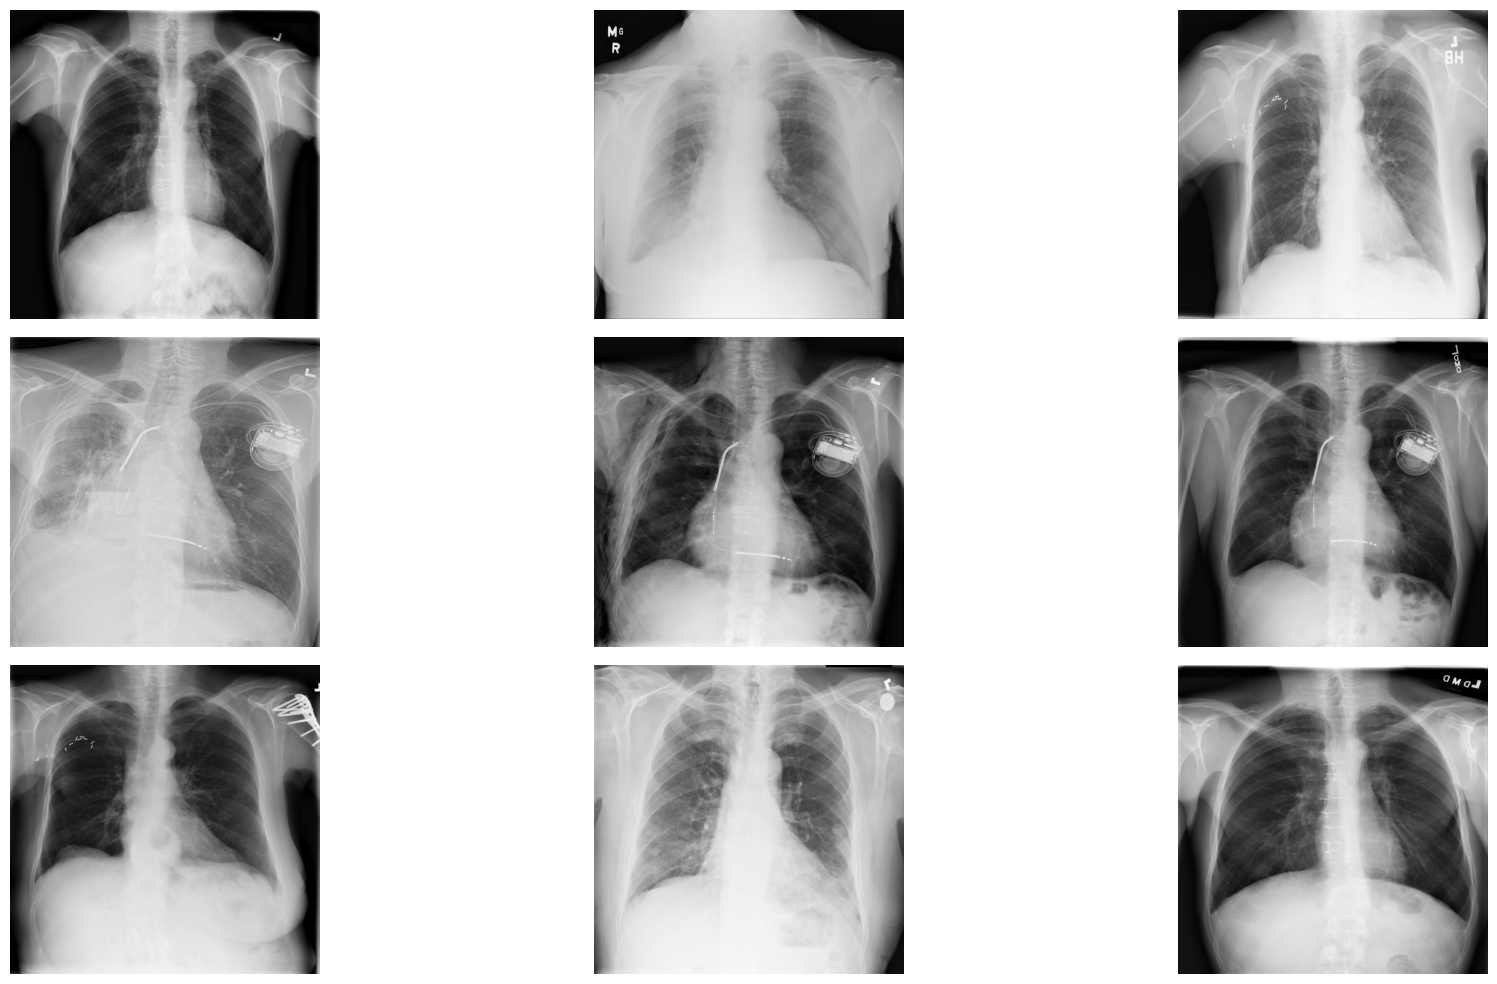

In [12]:
# img_dir = '../assets_main/images-selected/images_001/images/'
img_dir = "imagedata"
# Extract numpy values from Image column in data frame
image_files = [os.path.join(img_dir, file_name) for file_name in os.listdir(img_dir)
               if file_name.endswith((".png"))]

# Select 9 random image files from the list
random_images = random.sample(image_files, 9)

# Do something with the random image files
# for image_file in random_images:
#     print("Random image selected:", image_file)

# Location of the image dir

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # img = plt.imread(os.path.join(img_dir, random_images[i]))
    img = plt.imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

### Investigate a single image
Look at the first image in the dataset and print out some details of the image contents.

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.4940 and the standard deviation is 0.2064


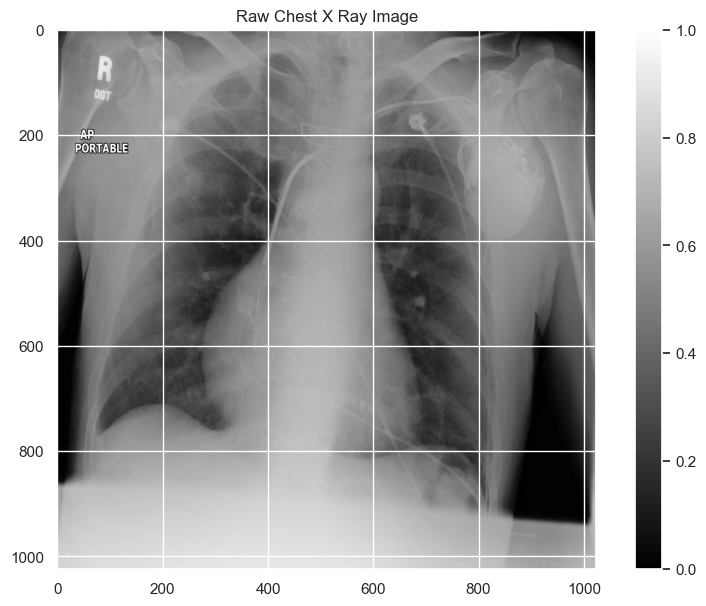

In [13]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.id[40]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Investigate pixel value distribution
Plot up the distribution of pixel values in the image shown above. 

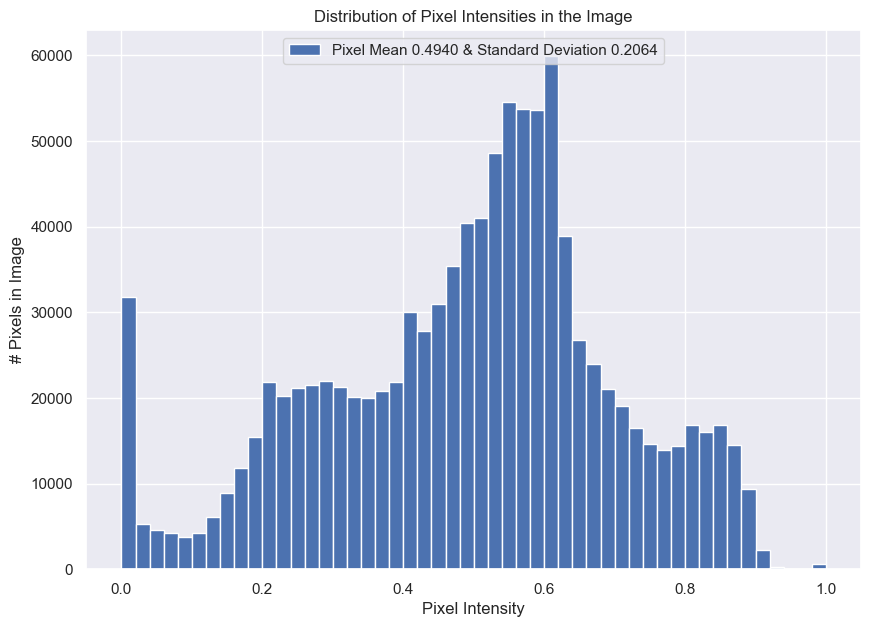

In [14]:
pixels = np.reshape(raw_image, raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()


# Image Preprocessing in Keras
### Standardization

<!-- Normalizing images is better suited for training a convolutional neural network. For this task we use the Keras [ImageDataGenerator](https://keras.io/preprocessing/image/) function to perform data preprocessing and data augmentation.
The `image_generator` will adjust the image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.  

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

$$\frac{x_i - \mu}{\sigma}$$

Create an image generator for preprocessing. Pre-process the data using the `image_generator`as well as reduce the image size down to 320x320 pixels. -->

In [15]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

In [16]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation
    
    # flow from directory with specified batch size and target image size
    # flow_from_dataframe ==> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    # RETURNS a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with 
    # shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels
    # default data format of ImageGenerator is channels _last
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",       #  Mode for yielding the targets, one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical".
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    print("--------end of train--------")
    return generator

In [17]:
# def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, 
#                                  seed=1, target_w = 320, target_h = 320):
#     """
#     Return generator for validation set and test test set using 
#     normalization statistics from training set.

#     Args:
#       valid_df (dataframe): dataframe specifying validation data.
#       test_df (dataframe): dataframe specifying test data.
#       train_df (dataframe): dataframe specifying training data.
#       image_dir (str): directory where image files are held.
#       x_col (str): name of column in df that holds filenames.
#       y_cols (list): list of strings that hold y labels for images.
#       sample_size (int): size of sample to use for normalization statistics.
#       batch_size (int): images per batch to be fed into model during training.
#       seed (int): random seed.
#       target_w (int): final width of input images.
#       target_h (int): final height of input images.
    
#     Returns:
#         test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
#     """
#     # get generator to sample dataset
#     print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")
#     #labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis','Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
#     #IMAGE_DIR = "/kaggle/input/nih-chestdata/"
#     #IMAGE_DIR = "C:/Users/hp/Downloads/images/images/"
#     raw_train_generator = ImageDataGenerator().flow_from_dataframe(
#         dataframe=train_df, 
#         directory=IMAGE_DIR, 
#         x_col="id", 
#         y_col=labels, 
#         class_mode="raw", 
#         batch_size=sample_size, 
#         shuffle=True, 
#         target_size=(target_w, target_h))
    
#     # get data sample
#     batch = raw_train_generator.next() # generate a batch of samples and associated labels 
#     data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

#     # use sample to fit mean and std for test set generator
#     image_generator = ImageDataGenerator(
#         featurewise_center=True,
#         featurewise_std_normalization= True)
    
#     # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
#     image_generator.fit(data_sample)
    
#     print("\ngetting valid generator...")

# #     x_col = 'id'
# #     get test generator
#     valid_generator = image_generator.flow_from_dataframe(
#             dataframe=valid_df,
#             directory=image_dir,
#             x_col=x_col,
#             y_col=y_cols,
#             class_mode="raw",
#             batch_size=batch_size,
#             shuffle=False,
#             seed=seed,
#             target_size=(target_w,target_h))
    
    
#     print("\ngetting test generator...")
#     test_generator = image_generator.flow_from_dataframe(
#             dataframe=test_df,
#             directory=image_dir,
#             x_col=x_col,
#             y_col=y_cols,
#             class_mode="raw",
#             batch_size=batch_size,
#             shuffle=False,
#             seed=seed,
#             target_size=(target_w,target_h))
# #     return test_generator
#     return valid_generator, test_generator


In [18]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, 
                                 seed=1, target_w=320, target_h=320):
    """
    Return generator for validation set and test set using 
    normalization statistics from the training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of the column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into the model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set, respectively
    """
    # Get generator to sample the dataset
    print(f"\nExtracting {sample_size} train images to normalize validation and test datasets...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # Get data sample
    batch = raw_train_generator.next()  # Generate a batch of samples and associated labels
    data_sample = batch[0]              # We only need the sample images, i.e., batch[0]

    # Use the sample to fit mean and std for the test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True)
    
    # Fit generator to sample from training data
    image_generator.fit(data_sample)
    
    print("\nGetting valid generator...")
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=valid_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h))
    
    print("\nGetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h))

    return valid_generator, test_generator


In [19]:
IMAGE_DIR = r"D:\images\images"

# Verify the column names in the DataFrame and use the correct ones
train_col_name = "id"
train_labels_col_name = "Labels"
valid_col_name = "id"
test_col_name = "id"

# Generate the train, validation, and test generators
train_generator = get_train_generator(train_df, IMAGE_DIR, train_col_name, train_labels_col_name)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, valid_col_name, test_col_name)


getting train generator...
Found 900 validated image filenames.
--------end of train--------

Extracting 100 train images to normalize validation and test datasets...
Found 900 validated image filenames.

Getting valid generator...
Found 99 validated image filenames.

Getting test generator...


KeyError: 'id'

In [20]:
# # Define the list of labels
# labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
#           'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation', 'No Finding']

# # Check if all labels are present in the DataFrame columns
# missing_labels = [label for label in labels if label not in train_df.columns]
# if missing_labels:
#     raise ValueError(f"The following labels are missing in the DataFrame columns: {missing_labels}")

# Continue with the code to generate the train, validation, and test generators
IMAGE_DIR = "imagedata"
train_generator = get_train_generator(train_df, IMAGE_DIR, "id", "Labels")
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "id", "Labels")


getting train generator...
Found 42 validated image filenames.
--------end of train--------

Extracting 100 train images to normalize validation and test datasets...
Found 42 validated image filenames.


Found 858 invalid image filename(s) in x_col="id". These filename(s) will be ignored.



Getting valid generator...
Found 0 validated image filenames.

Getting test generator...


Found 99 invalid image filename(s) in x_col="id". These filename(s) will be ignored.


KeyError: 'id'

In [21]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation','No Finding']
# IMAGE_DIR = "../assets_main/images-selected/images_001/images/"
# IMAGE_DIR = "C:\\Users\\hp\\Downloads\\images\\images"
IMAGE_DIR = "imagedata"
train_generator = get_train_generator(train_df, IMAGE_DIR, "id", labels)
# x_col_name = 'id'  # replace 'id' with the actual column name
# valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, IMAGE_DIR, x_col_name, labels)

valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "id", labels)
#test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "image_id", labels)

getting train generator...


Found 858 invalid image filename(s) in x_col="id". These filename(s) will be ignored.


KeyError: "None of [Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',\n       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',\n       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation', 'No Finding'],\n      dtype='object')] are in the [columns]"

In [22]:
# print(valid_df.columns)
# print(test_df.columns)
# print(train_df.columns)
# print('----------------------------')
# valid_df = valid_df.rename(columns={'id': 'image_id'})
# test_df = test_df.rename(columns={'id': 'image_id'})
# print('----------------------------')
# print(valid_df.columns)
# print(test_df.columns)
# print('----------------------------')
# valid_df = valid_df.rename(columns={'image_id': 'id'})
# test_df = test_df.rename(columns={'image_id': 'id'})
# print('----------------------------')
# print(valid_df.columns)
# print(test_df.columns)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.4516 and the minimum is -2.8201
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


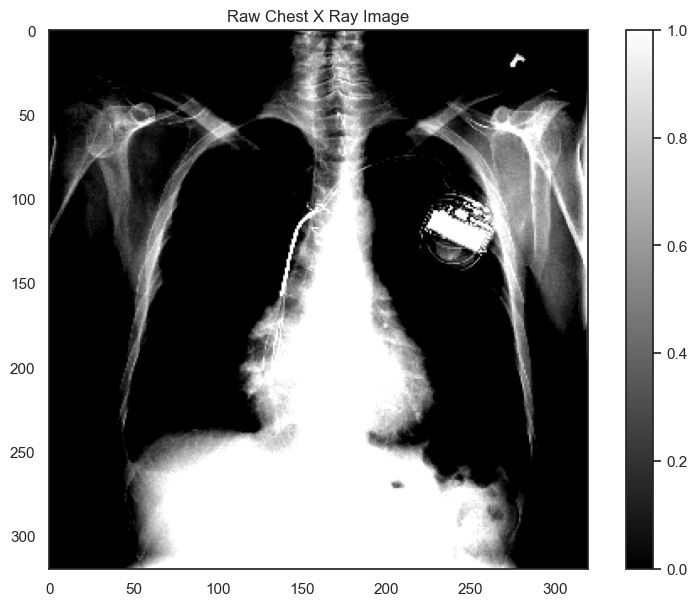

In [23]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [24]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 320, 320, 3) (320, 320, 3)
(1024, 1024)




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



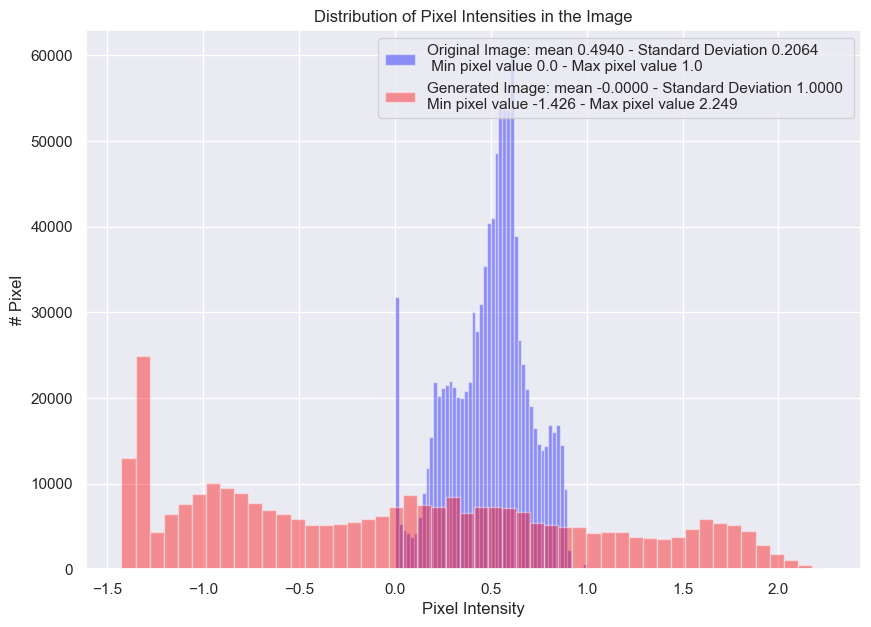

In [25]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(), 
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

### Addressing Class Imbalance - Weighted Loss
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

In [29]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation','No Finding']

In [30]:
import matplotlib.pyplot as plt

# Calculate the class frequencies
class_frequencies = np.mean(train_generator.labels.astype(float), axis=0)

# Plot the bar chart
plt.bar(x=labels, height=class_frequencies)
plt.title("Frequency of Each Class")
plt.xticks(rotation=90)
plt.show()


ValueError: could not convert string to float: 'Infiltration|Mass'

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

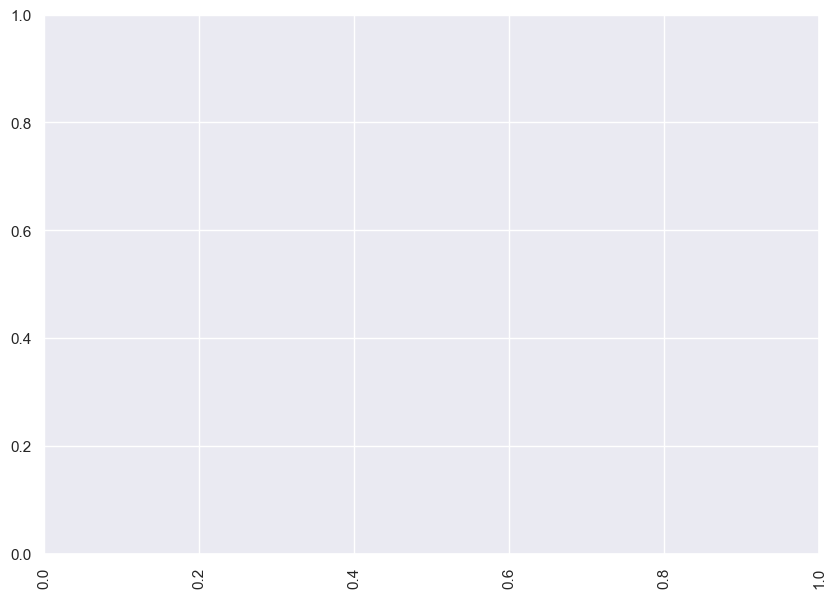

In [31]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

#### Impact of class imbalance on loss function

<!-- Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$ -->

### Computing Class Frequencies

In [32]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [150]:
def compute_class_freqs(labels):
    """
    Compute positive and negative class frequencies.

    Args:
        labels (numpy array): Array of labels.

    Returns:
        positive_frequencies (numpy array): Array of positive class frequencies.
        negative_frequencies (numpy array): Array of negative class frequencies.
    """
    # Convert labels to numerical values
    labels_numeric = labels.astype(int)

    # Total number of samples
    N = labels.shape[0]

    # Calculate positive and negative frequencies
    positive_frequencies = np.sum(labels_numeric, axis=0) / N
    negative_frequencies = (N - np.sum(labels_numeric, axis=0)) / N

    return positive_frequencies, negative_frequencies

# Compute class frequencies using train_generator.labels
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

ValueError: invalid literal for int() with base 10: 'Cardiomegaly'

In [146]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [91]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
neg_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])
data = pd.concat([data, neg_data], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)


NameError: name 'freq_pos' is not defined

The contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 



This way, we will be balancing the contribution of positive and negative labels.

In [92]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

NameError: name 'freq_neg' is not defined

Let's verify this by graphing the two contributions next to each other :

In [93]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
neg_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)])
data = pd.concat([data, neg_data], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

NameError: name 'pos_contribution' is not defined

<!-- After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$ -->

### Weighted Loss

In [94]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # Cast y_true and y_pred to float32
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.cast(y_pred, dtype='float32')
        
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon))
            
        return loss
        
    return weighted_loss

### DenseNet121
Use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model.Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network
- The first layer is connected to the 2nd, 3rd, 4th etc.
- The second layer is connected to the 3rd, 4th, 5th etc.
- For a detailed explanation of Densenet, check out the source of the image above, a paper by Gao Huang et al. 2018 called [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).
<img src="densenet.png" alt="U-net Image" width="400" align="middle"/>

we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

In [95]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():
   
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights=None, include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(labels), activation="softmax")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights("C:\\Users\\hp\\Downloads\\weights.h5", by_name=True)
    print("Loaded Weights")
    return model

#model = load_C3M3_model()

In [96]:
model = load_C3M3_model()

KeyError: "None of [Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',\n       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',\n       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],\n      dtype='object')] are in the [columns]"

let's see the layers that our model is composed of.

In [97]:
model.summary()

NameError: name 'model' is not defined

In [98]:
# Print out the total number of layers
layers_ = model.layers
print('total number of layers =',len(layers_))

NameError: name 'model' is not defined

In [33]:
# The find() method returns an integer value:
# If substring doesn't exist inside the string, it returns -1, otherwise returns first occurence index
conv2D_layers = [layer for layer in model.layers 
                if str(type(layer)).find('Conv2D') > -1]

In [34]:
print('Model input -------------->', model.input)
print('Feature extractor output ->', model.get_layer('conv5_block16_concat').output)
print('Model output ------------->', model.output)

Model input --------------> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Feature extractor output -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='conv5_block16_concat/concat:0', description="created by layer 'conv5_block16_concat'")
Model output -------------> KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")


## Training

In [ ]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 100)



In [ ]:
print(history.history['loss'])
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

## Prediction and Evaluation
Now that we have a model, let's evaluate it using our test set. We can conveniently use the predict_generator function to generate the predictions for the images in our test set.

In [37]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

(420, 14)

### ROC Curve and AUROC
Compute metric called the AUC (Area Under the Curve) from the ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. ideally we want a curve that is more to the left so that the top has more "area" under it, which indicates that the model is performing better.

In [68]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

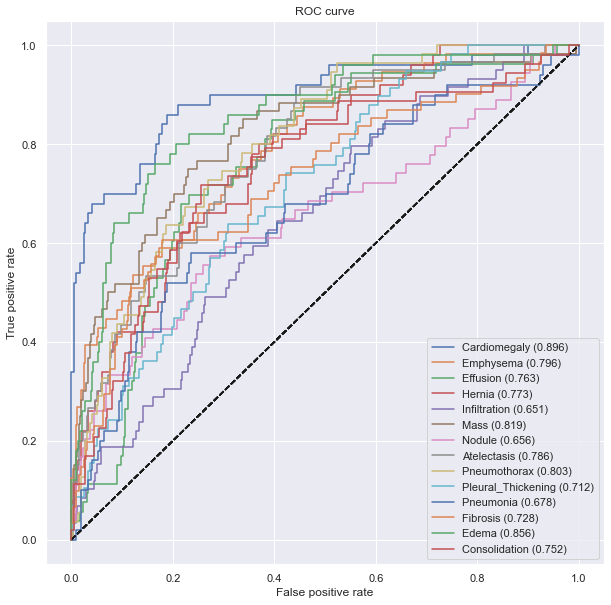

In [69]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [40]:
print("areas under the curve : {} \n for all {} classes".format(auc_rocs,len(auc_rocs)))

areas under the curve : [0.8960540540540539, 0.7963598901098901, 0.7626343118605727, 0.7731351351351351, 0.650828677402695, 0.8193055555555555, 0.6556871078729002, 0.785787037037037, 0.802640099626401, 0.7123737854829492, 0.678, 0.7279327823188274, 0.8563243243243243, 0.7516837180607682] 
 for all 14 classes


Now we are ready to normalize and run the image through our model to get predictions.

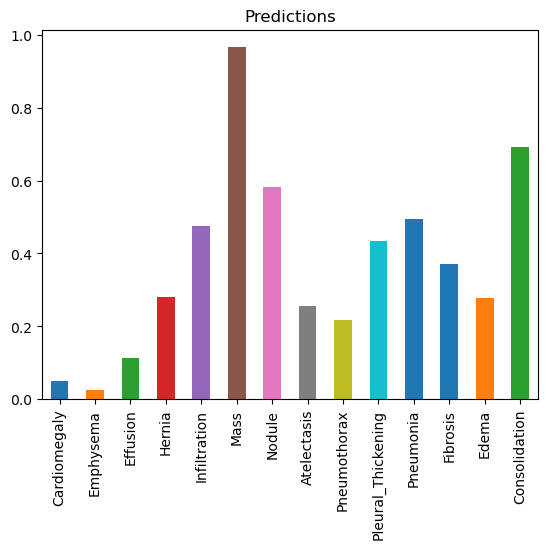

In [72]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()

In [46]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.049361,0.025269,0.113772,0.280401,0.475629,0.96631,0.582365,0.256831,0.216697,0.433484,0.494812,0.37037,0.279044,0.690861
